# Entrega N - Título

### Grupo M:
     - D. Garat  C.I...
     - G. Moncecchi C.I...



## 1. Objetivo

El objetivo de esta tarea es construir un jugador/clasificador/... utilizando... . 

El éxito del aprendizaje se mide a través de...


## 2. Diseño

En esta sección se deben presentar las decisiones tomadas a la hora de implementar el jugador, clasificador, etc.


## 2.1 Preprocesamiento de datos
- Decisiones sobre tratamiento de datos numéricos, faltantes, etc. antes de la aplicación de el algoritmo
- Selección/generación de atributos


In [1]:
import subprocess
subprocess.run(["./get_data.sh"], shell=True)

Archive:  ./data.zip
 extracting: ./assets/data.csv       
ZIP file downloaded, extracted, and deleted.


CompletedProcess(args=['./get_data.sh'], returncode=0)

In [2]:
import pandas as pd
from sklearn import model_selection

from src import campo_continuo as cc

dataset_file = "./assets/data.csv"
dataset = pd.read_csv(dataset_file, sep=";")

columnas_continuas_name = ['Previous qualification (grade)', 'Admission grade', 'Unemployment rate', 'Inflation rate', 'GDP']
columnas_continuas = [cc.CampoContinuo(column_name) for column_name in columnas_continuas_name]
# Select specific columns and calculate statistics
column_stats = dataset[columnas_continuas_name].agg(['mean', 'max', 'min'])

for column in columnas_continuas:
    column.rangos(column_stats[column.nombre]['max'], column_stats[column.nombre]['mean'], column_stats[column.nombre]['min'])
    dataset[column.nombre] = dataset[column.nombre].apply(column.calificar)



Prueba:

In [3]:
print("{} records read from {}\n{} attributes found".format(dataset.shape[0], dataset_file, dataset.shape[1]))
dataset.head(5)

4424 records read from ./assets/data.csv
37 attributes found


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,1,1,19,12,...,0,0,0,0,0.000000,0,1,2,2,Dropout
1,1,15,1,9254,1,1,2,1,1,3,...,0,6,6,6,13.666667,0,3,0,2,Graduate
2,1,1,5,9070,1,1,1,1,37,37,...,0,6,0,0,0.000000,0,1,2,2,Dropout
3,1,17,2,9773,1,1,1,1,38,37,...,0,6,10,5,12.400000,0,0,0,0,Graduate
4,2,39,1,8014,0,1,0,1,37,38,...,0,6,6,6,13.000000,0,3,0,2,Graduate


- Convertir datos de la columna "Target" en datos númericos

In [4]:
from sklearn import preprocessing

# creamos un codificador "ordinal" y lo ajustamos a la columna Target
enc = preprocessing.OrdinalEncoder()
enc.fit(dataset[['Target']])
for i, cat in enumerate(enc.categories_[0]): print("{} -> {}".format(cat, i))


#transformamos la columna y la guardamos en una nueva columna
dataset['Target']  = enc.transform(dataset[['Target']])

#salida
dataset.head(5)

dataset = dataset.astype(int) 

train, test = model_selection.train_test_split(dataset, test_size=0.2, random_state=42)

Dropout -> 0
Enrolled -> 1
Graduate -> 2




## 2.2 Algoritmo
Extensiones del algoritmo original necesarias para la resolución del problema: tratamiento de atributos faltantes, numéricos, etc. (si es el propio algoritmo el que lo maneja), implementaciones adicionales necesarias para manejar ensambles de clasificadores, etc.

Algoritmo básico
* Crear una raíz
* Si todos los ej. tienen el mismo valor → etiquetar con ese valor
* Si no me quedan atributos → etiquetar con el valor más común
* En caso contrario:
    * La raíz pregunta por A, atributo que mejor clasifica los ejemplos
    * Para cada valor v_i de A
        * Genero una rama
        * Ejemplosvi={ejemplos en los cuales A=vi }
        * Si Ejemplosvi es vacío → etiquetar con el valor más probable
        * En caso contrario → ID3(Ejemplosvi, Atributos -{A})

In [5]:
import pandas as pd
import numpy as np

from src.nodo import Nodo
from src.utils import get_best_attribute

MIN_SAMPLES_SPLIT = 0
MIN_SPLIT_GAIN = 0

### ID3 PAPU, NACIONAL > PENADOY
def id3(data: pd.DataFrame, attributes, target, attr, value) -> Nodo:
    # Caso base 1: todos los datos tienen la misma clase
    if data[target].nunique() == 1:
        return Nodo(attr, value, tipo=Nodo.hoja, resultado=data[target].unique()[0], n_casos=data.shape[0])
    # Caso base 2: no hay mas atributos
    elif len(attributes) == 0:
        return Nodo(attr, value, tipo=Nodo.hoja, resultado=data[target].mode()[0], n_casos=data.shape[0])

    # Caso recursivo
    else:
        # Seleccionar el mejor atributo
        best_attribute, gain, unique_values = get_best_attribute(data, attributes, target)
        # if gain < MIN_SPLIT_GAIN:
        #     print_value(value)
        #     return Nodo(attr, value, tipo=Nodo.hoja, resultado=data[target].mode()[0])
        
        # if len(unique_values) < MIN_SAMPLES_SPLIT:
        #     print_value(value)
        #     return Nodo(attr, value, tipo=Nodo.hoja, resultado=data[target].mode()[0])

        # Eliminar el atributo de la lista de atributos
        attributes = attributes[attributes != best_attribute]
        # Crear un nodo hijo por cada valor del atributo
        children = []
        for child_value in unique_values:
            subdata = data[data[best_attribute] == child_value]
            child = id3(subdata, attributes, target, best_attribute, child_value)
            children.append(child)

        return Nodo(attr, value, tipo=Nodo.rama, hijos=children, n_casos=data.shape[0])
    
dataset_headers = dataset.columns.values
dataset_headers = dataset_headers[dataset_headers != 'Target']
# dataset_headers = dataset_headers[dataset_headers != 'output']

arbol = id3(train, dataset_headers[dataset_headers != 'Target'], 'Target', 'root', 0)



## 2.3 Evaluación
- Qué conjunto de métricas se utilizan para la evaluación de la solución y su definición
- Sobre qué conjunto(s) se realiza el entrenamiento, ajuste de la solución, evaluación, etc. Explicar cómo se construyen estos conjuntos.

In [12]:
from src.nodo import Nodo

# Dropout -> 0
# Enrolled -> 1
# Graduate -> 2

hits = {
    "Dropout": 0,
    "Enrolled": 0,
    "Graduate": 0
}

misses = {
    "Dropout": {
        "Predicted Enrolled": 0,
        "Predicted Graduate": 0
    },
    "Enrolled": {
        "Predicted Dropout": 0,
        "Predicted Graduate": 0
    },
    "Graduate": {
        "Predicted Dropout": 0,
        "Predicted Enrolled": 0
    }
}

def output_to_str(output):
    if output == 0:
        return "Dropout"
    elif output == 1:
        return "Enrolled"
    elif output == 2:
        return "Graduate"
    else:
        raise ValueError("Output must be 0, 1 or 2")


def get_next_node(row, nodo):
    max_n_casos = 0
    max_n_casos_hijo = None

    for hijo in nodo.hijos:
        if hijo.n_casos > max_n_casos:
            max_n_casos = hijo.n_casos
            max_n_casos_hijo = hijo
        if hijo.valor == row[hijo.attr]:
            return hijo

    return max_n_casos_hijo


def get_result(row, nodo):
    if nodo.tipo == Nodo.hoja:
        return nodo.resultado
    else:
        return get_result(row, get_next_node(row, nodo))


# Loop through rows using iterrows()
for index, row in test.iterrows():
    result = get_result(row, arbol)
    if result == row['Target']:
        hits[output_to_str(row['Target'])] += 1
    else:
        misses[output_to_str(row['Target'])]["Predicted " + output_to_str(result)] += 1


print("Hits: ", hits)
print("Misses: ", misses)

Hits:  {'Dropout': 209, 'Enrolled': 44, 'Graduate': 334}
Misses:  {'Dropout': {'Predicted Enrolled': 45, 'Predicted Graduate': 62}, 'Enrolled': {'Predicted Dropout': 51, 'Predicted Graduate': 56}, 'Graduate': {'Predicted Dropout': 43, 'Predicted Enrolled': 41}}


## 3. Experimentación

- Presentar los distintos experimentos que se realizan y los resultados que se obtienen.

- La información de los resultados se presenta en tablas y en gráficos, de acuerdo a su naturaleza. Por ejemplo:

_En la gráfica 1, se observa el error cuadrático total del conjunto de entrenamiento a medida que pasan los juegos para el oponente X_

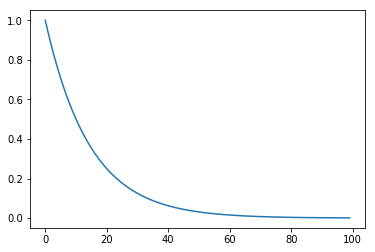

In [ ]:
import matplotlib.pyplot
matplotlib.pyplot.plot(range(0,100), [2**-(x/10) for x in range(0,100)])


- Debe existir alguna instancia donde se compile la información relevante de los experimentos de forma de poder comparar fácilmente los distintos experimentos. Por ejemplo:

_En la tabla 1, se presentan los distintos resultados contra el jugador aleatorio, para los distintos valores de $\alpha$ elegidos. El mejor resultado se obtiene para $\alpha=0.05$, lo que prueba que la estrategia..._

<table>
  <tr>
    <th>$\alpha$</th>
    <th>...</th>
    <th>Turnos</th>
    <th>Error</th>
  </tr>
  <tr>
    <td>0.001</td>
    <td>...</td>
    <td>100</td>
    <td>0.991</td>
  </tr>    
  <tr>
    <td>0.005</td>
    <td>...</td>
    <td>100</td>
    <td>0.987</td>
  </tr>
  <tr style="font-weight:bold">
    <td>0.05</td>
    <td>...</td>
    <td>100</td>
    <td>0.329</td>
  </tr>
  <tr>
    <td>0.5</td>
    <td>...</td>
    <td>100</td>
    <td>0.564</td>
  </tr>    
    <caption>Tabla 1 - Entrenamiento del jugador X para distintos valores de $\alpha$</caption>
</table>


## 4. Conclusión

Una breve conclusión del trabajo realizado. Por ejemplo: 
- ¿cuándo se dieron los mejores resultados del jugador?
- ¿encuentra alguna relación con los parámetros / oponentes/ atributos elegidos?
- ¿cómo mejoraría los resultados?